### Pytania

1. Czy to normalne że się zapętla to drzewo? Co robić z tym: albo zakazywać stanów, a może zakazywać ruchów na jakiś czas (tak jak w TabuSearch)
2. Jeśli tak, to czy te gałęzie, które już odwiedziliśmy mamy po prostu omijać, czy je ewaluować? 
3. Czy ma sens dawać taką głębokość drzewa, że ostatnim ruchem jest ruch przeciwnika? Bo wtedy naturalnie zawsze gorsze ruchy będą, niż gdyby to o ostatnim ruchu decydował Max
4. Co oznacza adaptacyjność heurystyk
5. Czy strategia oznacza to, jak oceniamy szanse bez analizowania drzewa, tj. tylko na podstawie aktualnego stanu, czy też to, które ruchy wybieramy (normalnie testuje każdy możliwy ruch).
6. Czy alpha-beta powinno dawać taki sam ruch? Czy taką samą wartość (wtedy ruch może być inny)?
7. Czy to normalne, że pod koniec algorytm błądzi między tymi samymi stanami? Czy można np. zakazać mu przechodzić do stanu, jeśli przed chwilą tam był? (na wzór tabu-search)

Nie trzeba obliczać dla przeciwnika wartości. Czas dla roznych glebokosci, brak heurystyki. Dwa ruchy na raz  

Która strategia wygrała najczęściej?
Który algorytm wygrał najczęściej?

### Gry logiczne i SI

W ramach tego labolatorium zadaniem było zaimplementowanie gry *Halma* z wykorzystaniem algorytmów **Min-Max** i **Alpha-beta**, oraz heurystykami wyznaczającymi strategie. 

### Implementacja

Za logikę gry odpowiadają klasy *Engine* i *Game State*, które inicjalizują stan gry, generują kolejne możliwe ruchy i je walidują, oraz sprawdzają, czy gra już się skończyła. Interfejs *GameAdapter* służy jako pośrednik umożliwiający rozegranie gry w sposób na żywo, lub odtworzenie już rozegranej gry. Klasa *Player* reprezentuje gracza oraz posiada funkcję **evaluate**, która określa na podstawie stanu gry jak bardzo duże szansę ma na wygraną w takim ustawieniu. Każda konkretna podklasa reprezentuje jedną z heurystyk. 

##### DistancePlayer
W tym przypadku wykorzystywana jest najbliższa odległość do granic przeciwległego obozu - im bliżej, tym wartość jest mniejsza, więc brana jest wartość ujemna.

##### StaticWeightsPlayer
Heurystyka ta przypisuje polom wagi, gdzie pola na tej samej przekątnej mają tą samą wartość - pola bliżej przeciwległego obozu mają lepsze dla danego gracza wagi.

##### AdaptiveWeightsPlayer
Heurystyka ta przypisuje polom wagi tak jak w metodzie wyżej, jednak z tą modyfikacją, że pola które znajdują się obok przeciwnika mają zmniejszoną wagę - w ten sposób unikamy zablokowania przez wroga lub też nie tworzymy dla niego możliwości większego skoku.

Warto podkreślić, że obliczane wartości dla różnych heurystyk nie powinny być ze sobą porównywane, gdyż są w różnych skalach. W ich obliczaniu nie bierzemy również pod uwagi rozmieszczenia wroga, ponieważ nie chcemy "siebie" karać za to, że przeciwnik ma, być może, lepszą heurystykę. 

#### Algorytmy przeszukiwania 
Klasa *SearchAlgorithm* określa interfejs dla algorytmów przeszukiwania drzewa decyzyjnego. Jako parametr przekazywana jest maksymalna głębokość drzewa, do której możemy przeszukiwać - dalej jest używana funkcja ewaluująca gracza.

#### MinMax
Jest on implementacją szablonowego min-max, gdzie zawsze od poziomu max rozpoczyna zawodnik, którego ruch akurat przypada. Poczyniono jednak następującą modyfikację: aby uniknąć odwiedzania tego samego stanu w drzewie wielokrotnie, wszystkie przebyte stany są kodowane przy pomocy funkcji haszującej (by nie porównywać za każdym razem tablic do siebie) i przetrzymywane w zbiorze stanów już odwiedzonych. Może więc dojść do tego, że z danego stanu nie odwiedzimy żadnych innych stanów, ponieważ zostały one już odwiedzone. 

#### AlphaBeta
Algorytm ten jest usprawnieniem MinMax polegającym na tym, że jeżeli w danym poddrzewie przeciwnik może wymusić na nas gorszy ruch, to nie przeszukujemy dalej tego drzewa. Warto zauważyć, że na danym poziomie może się zmienić tylko jeden parametr - alpha albo beta. Zauważono, że jeśli przy zmianie alpha zapamiętujemy również związany z tym ruch, to musi być to porównanie "silniejsze" (">", nie ">=") przy aktualizacji wartości. Przyjęto również tą samą zasadę niepowtarzania stanów, co wyżej.

W obu implementacjach w przypadku osiągnięcia liścia i zakończenia gry zwracana jest wartość $\infty$, gdy aktualny gracz wygrał, i $-\infty$, jeśli przegrał. Warto jednak zauważyć, że nie opłaca się wybierać głębokości drzew, na których ostatnim ruchem jest ruch przeciwnika, bo naturalnie on zawsze będzie wybierał te dla nas gorsze. Prawidłowa implementacja powinna również dla tego samego ustawienia gry, ale innych algorytmów, dla AlphaBeta dawać *nie gorsze* wyniki niż dla MinMax. Również  w miarę tego jak gra postępuje, wartości powinny być coraz mniejsze (zależy to też od heurystyki) - bo stan gry powinien się stawać coraz bardziej optymalny dla zawodników zakładając, że nasz przeciwnik jest "inteligentny". Jednak ta inteligencja jest też określona przez heurystykę - im lepsza, tym przeciwnik jest trudniejszy. 

In [2]:
import os

import pandas as pd 
import numpy as np 
from pathlib import Path

from IPython.display import Image
from IPython.core.display import HTML

from ai_data_eng.halma_game.evaluation.computation import *
from ai_data_eng.halma_game.evaluation.plotting import *
from ai_data_eng.halma_game.evaluation.reading import *


In [3]:
halma_dir = Path('../../data/halma/')

In [4]:
matches = [halma_dir / f'{d1}/{d2}/{d3}' 
           for d1 in os.listdir(halma_dir) 
           for d2 in os.listdir(halma_dir / d1) 
           for d3 in os.listdir(halma_dir / f'{d1}/{d2}')
           if d1 in ('m-alphabeta-m-alphabeta', 'm-minmax-m-minmax', 'minmax-minmax', 
                     'm-minmax-m-alphabeta')]

In [5]:
matches = {match_name(match_dir): read_match(match_dir) for match_dir in matches if len(os.listdir(match_dir)) >= 2}
for match_dir in matches:
    print(match_name(str(match_dir)))    

m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE
m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS
m-alphabeta-m-alphabeta_1-1_STRATEGY.DISTANCE-STRATEGY.STATIC_WEIGHTS
m-alphabeta-m-alphabeta_1-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS
m-alphabeta-m-alphabeta_2-1_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS
m-alphabeta-m-alphabeta_2-2_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE
m-alphabeta-m-alphabeta_2-2_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS
m-alphabeta-m-alphabeta_2-2_STRATEGY.DISTANCE-STRATEGY.STATIC_WEIGHTS
m-alphabeta-m-alphabeta_2-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS
m-alphabeta-m-alphabeta_3-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.DISTANCE
m-alphabeta-m-alphabeta_3-3_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE
m-alphabeta-m-alphabeta_3-3_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS
m-alphabeta-m-alphabeta_3-3_STRATEGY.DISTANCE-STRATEGY.STATIC_WEIGHTS
m-alphabeta-m-alphabeta_4-4_STRATEGY

In [6]:
matches['m-alphabeta-m-alphabeta_3-3_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE'][0]

,Move from,Move to,Compute time,Tree size,Eval value,Jump size
0,"0,2","2,4",0.92,2258,-1.51,4
1,"2,4","3,5",2.18,4496,-14.57,2
2,"0,3","4,5",2.89,5314,-14.10,6
3,"1,2","5,6",6.49,11980,-13.39,8
4,"1,0","3,6",10.80,19531,-12.79,8
5,"0,0","6,6",23.72,32030,-12.20,12
6,"2,0","4,4",31.48,40829,-11.48,6
7,"1,1","5,7",36.48,37247,-10.89,10
8,"0,4","6,8",25.79,30557,-10.18,10
9,"1,3","1,1",45.44,52163,-9.14,2


In [7]:
matches['m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE'][0].winner

'Black'

In [8]:
finished_matches = {k: matches[k] for k in matches if is_finished(matches[k])}
ongoing_matches = {k: matches[k] for k in matches if not is_finished(matches[k])}

In [9]:
print(finished_matches.keys())

dict_keys(['m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE', 'm-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS', 'm-alphabeta-m-alphabeta_1-1_STRATEGY.DISTANCE-STRATEGY.STATIC_WEIGHTS', 'm-alphabeta-m-alphabeta_1-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS', 'm-alphabeta-m-alphabeta_2-1_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS', 'm-alphabeta-m-alphabeta_2-2_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE', 'm-alphabeta-m-alphabeta_2-2_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS', 'm-alphabeta-m-alphabeta_2-2_STRATEGY.DISTANCE-STRATEGY.STATIC_WEIGHTS', 'm-alphabeta-m-alphabeta_2-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS', 'm-minmax-m-alphabeta_1-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.DISTANCE', 'm-minmax-m-alphabeta_2-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.DISTANCE', 'm-minmax-m-minmax_1-1_STRATEGY.DISTANCE-STRATEGY.ADAPTIVE_WEIGHTS', 'm-minmax-m-minmax_1-1_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS', 'm-m

In [10]:
print(ongoing_matches.keys())

dict_keys(['m-alphabeta-m-alphabeta_3-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.DISTANCE', 'm-alphabeta-m-alphabeta_3-3_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE', 'm-alphabeta-m-alphabeta_3-3_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS', 'm-alphabeta-m-alphabeta_3-3_STRATEGY.DISTANCE-STRATEGY.STATIC_WEIGHTS', 'm-alphabeta-m-alphabeta_4-4_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS', 'm-minmax-m-minmax_4-4_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS', 'm-minmax-m-minmax_6-6_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS', 'minmax-minmax_3-3_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.DISTANCE', 'minmax-minmax_3-3_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS', 'minmax-minmax_3-3_STRATEGY.DISTANCE-STRATEGY.STATIC_WEIGHTS'])


#### Problem - zawieszenie się stanu gry
 W przypadku algorytmu z wykorzystaniem zauważono, że nie jest on w stanie doprowadzić do końca gry. Wynika to prawdopodobnie z tej samej wartości dwóch pól (dwóch stanów). Gra "skacze" między dwoma takimi samymi stanami, co może doprowadzić do nieskończonej rekurencji. W celu uniknięcia tego, inspirując się tabu-search stworzony został 'Meta'algorytm, który używa obliczeń algorytmu przekazanego w konstruktorze, ale zapamiętuje stany w kolejce i zakazuje algorytmowi odwiedzać tych, które w niej są.
 

Jednak dla uproszczonej analizy algorytmów między sobą ten algorytm nie będzie rozważany oddzielnie.


![Title](./images/move_1.png)
![Title](./images/move_2.png)
![Title](./images/move_3.png)
![Title](./images/move_4.png)

#### Porównanie ciekawszych rozgrywek

Następnie porównamy między sobą zawodników w meczach (zakończonych lub nie)

Match between adaptive_weights VS static_weights, where winner is White


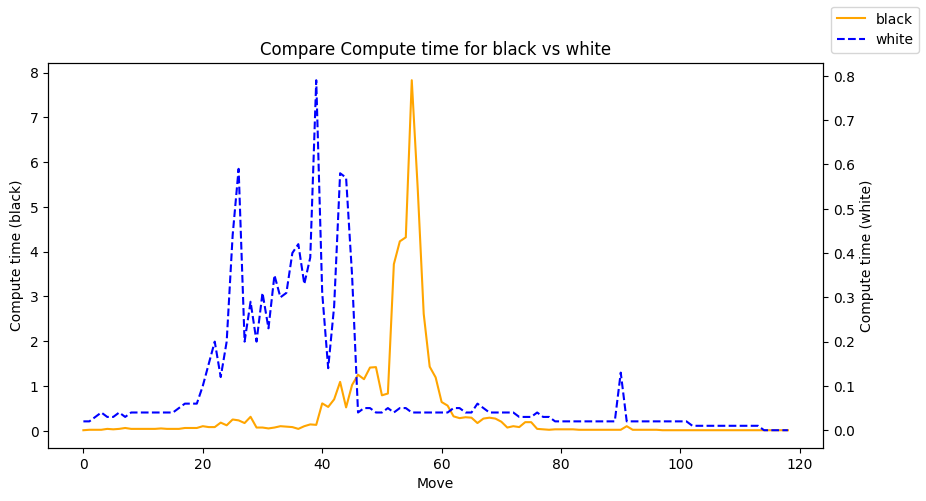

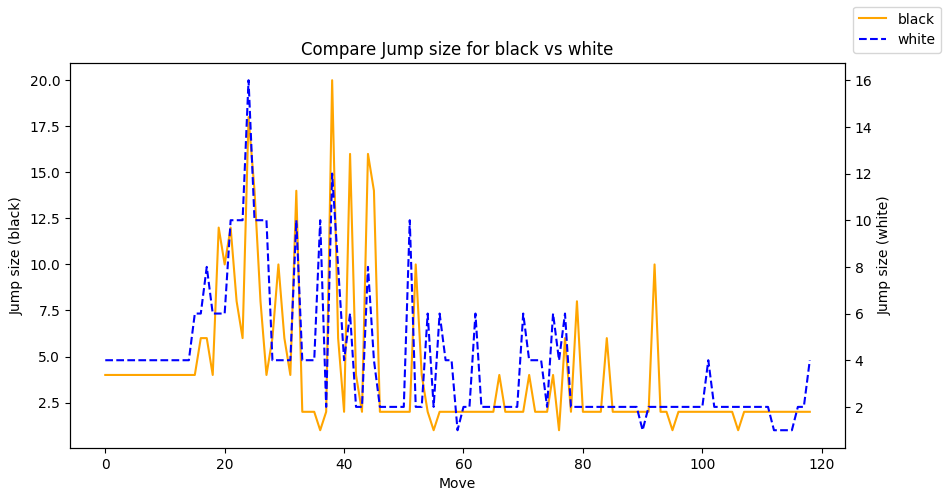

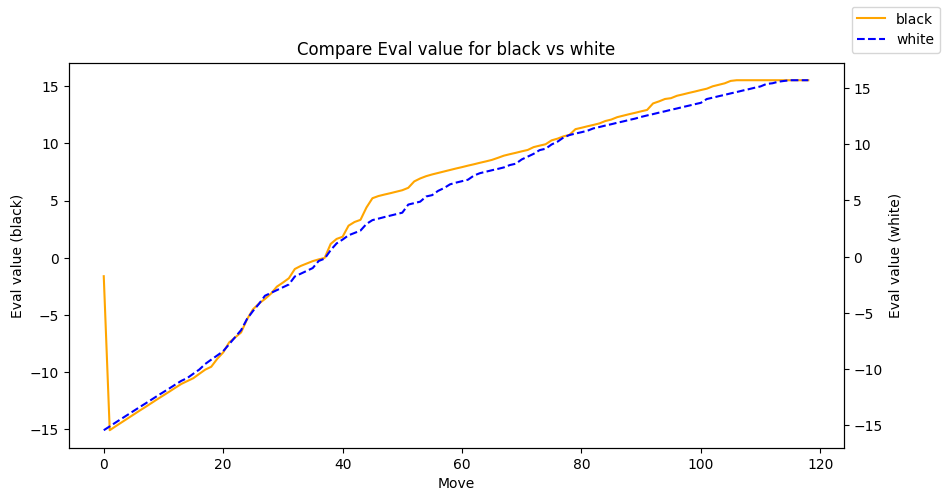

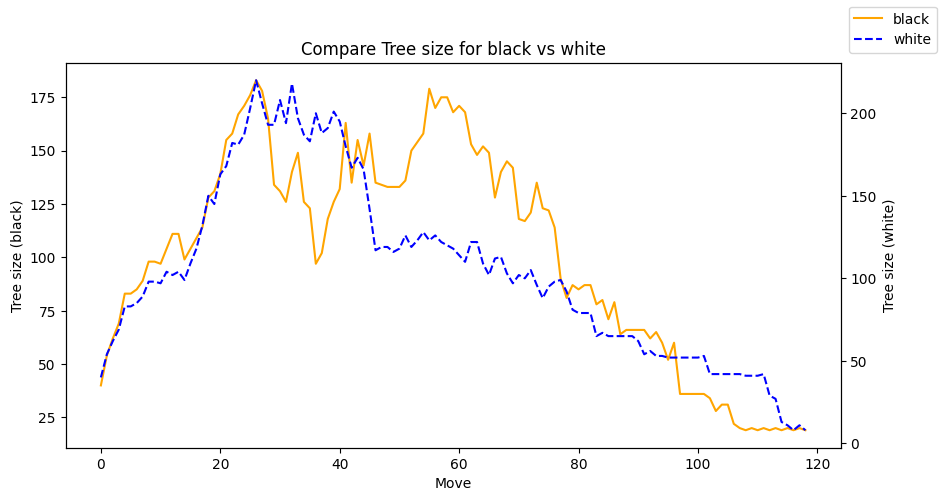

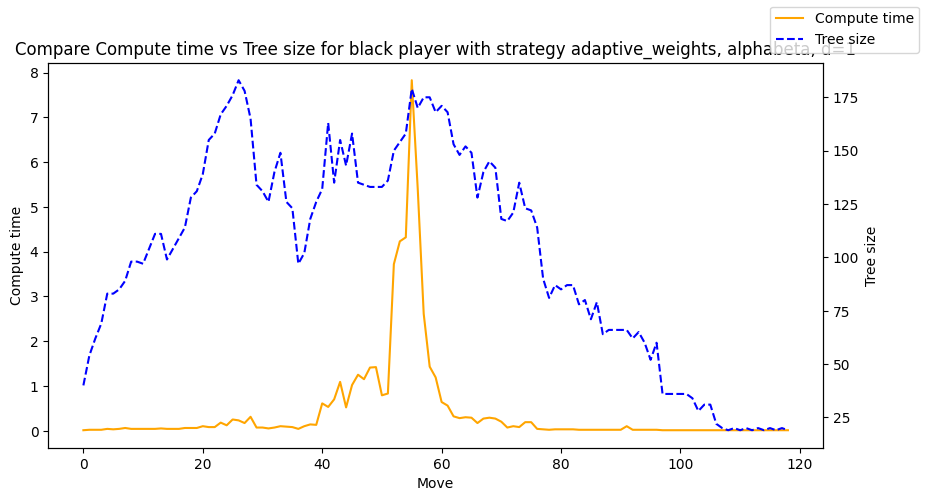

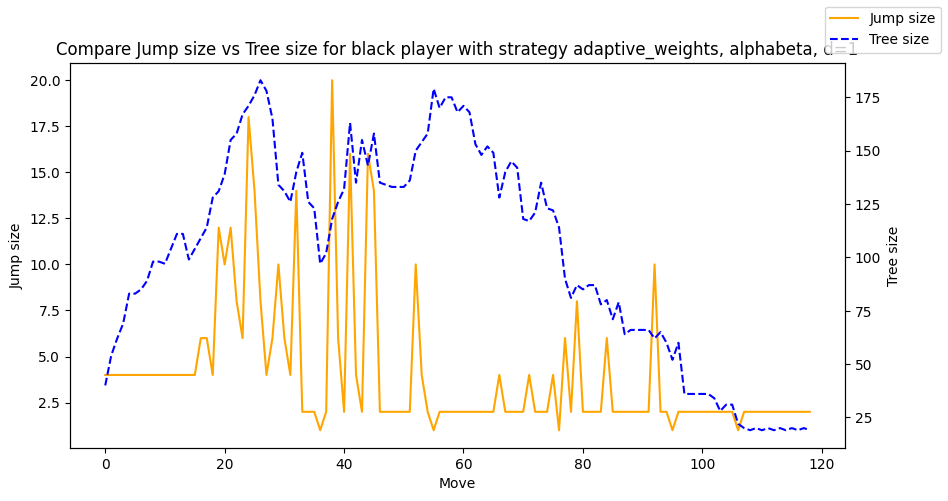

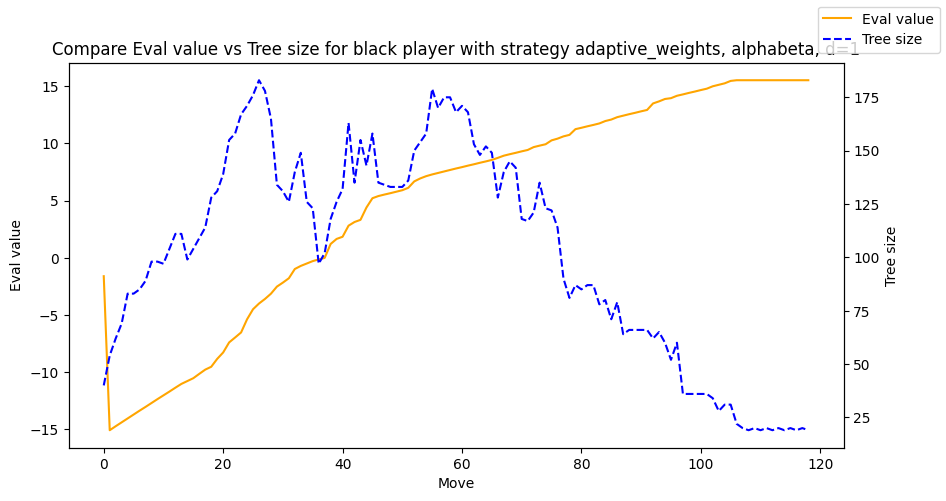

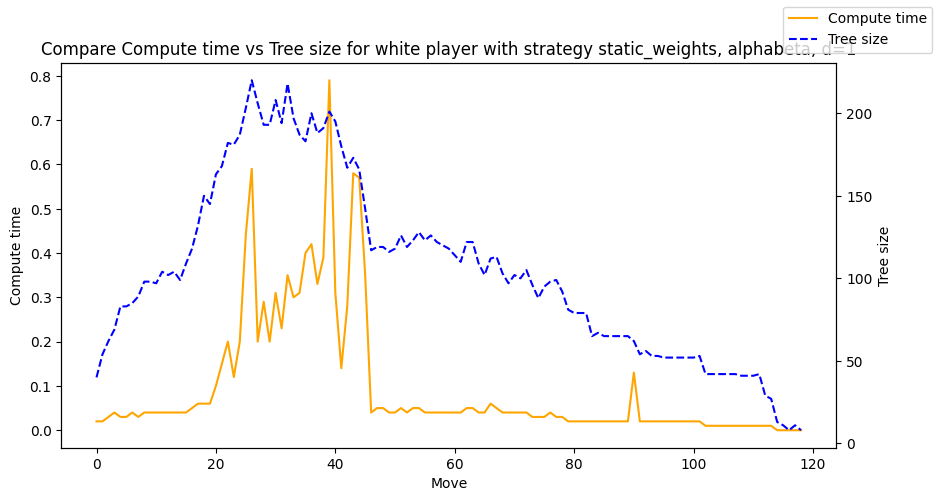

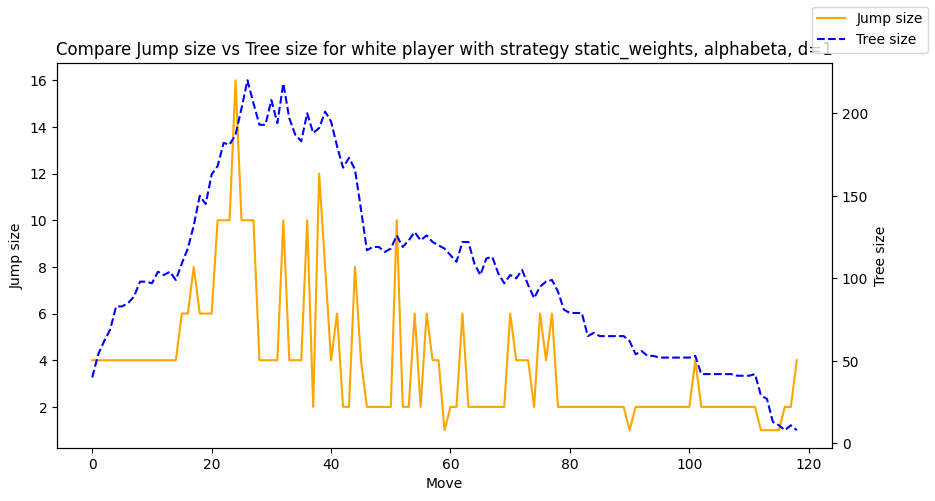

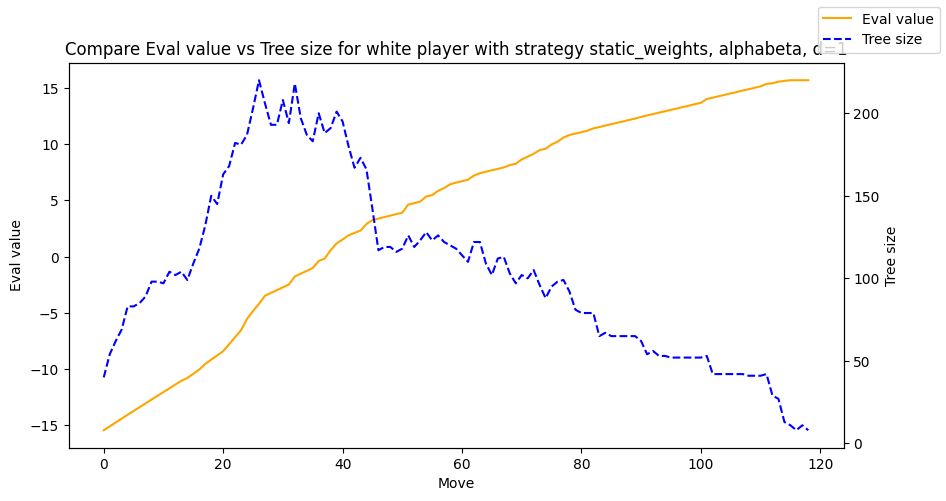

In [11]:
match_key = 'm-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_WEIGHTS-STRATEGY.STATIC_WEIGHTS'
print(match_info(matches[match_key]))
plot_compare_two_players(*matches[match_key], 'Compute time')
plot_compare_two_players(*matches[match_key], 'Jump size')
plot_compare_two_players(*matches[match_key], 'Eval value')
plot_compare_two_players(*matches[match_key], 'Tree size')
for player_id in range(2):
    plot_compare_two_variables(matches[match_key][player_id], 
                               'Compute time', 'Tree size')
    plot_compare_two_variables(matches[match_key][player_id], 
                               'Jump size', 'Tree size')
    plot_compare_two_variables(matches[match_key][player_id], 
                               'Eval value', 'Tree size')

#### Alpha-beta, głębokości 1 i 2 

Match between static_weights VS adaptive_weights, where winner is Black


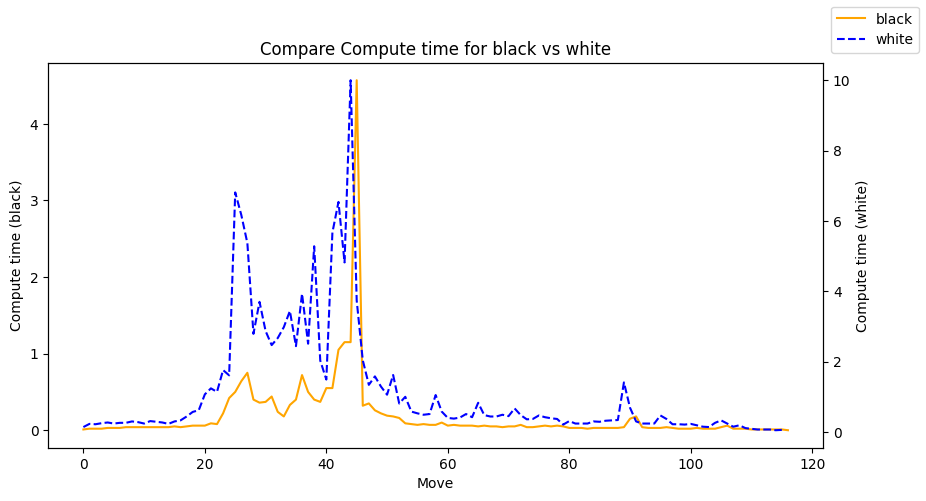

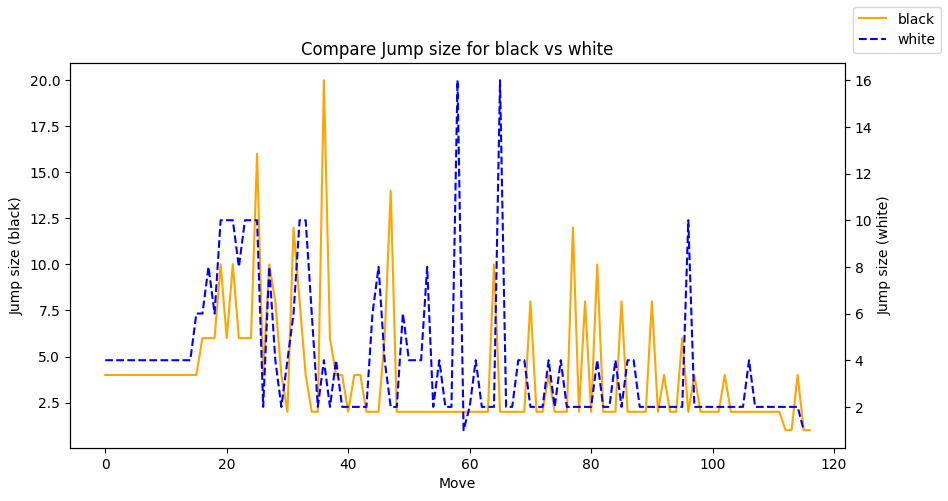

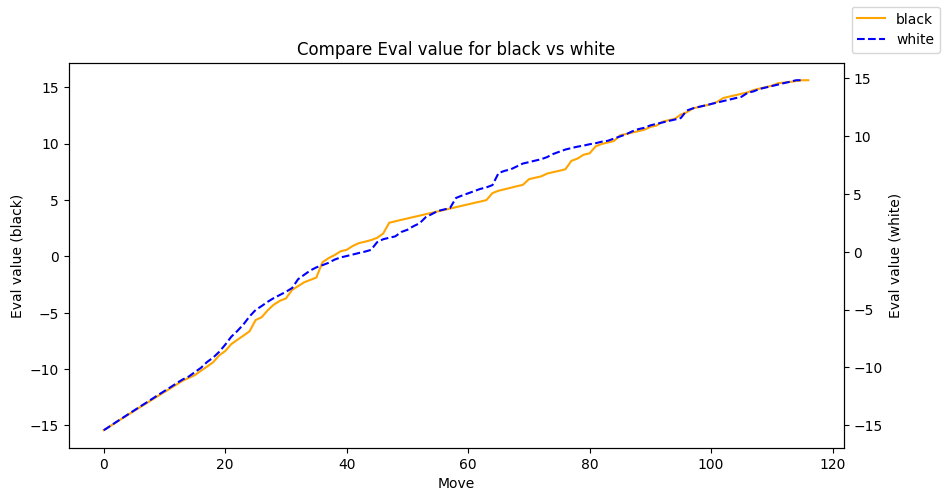

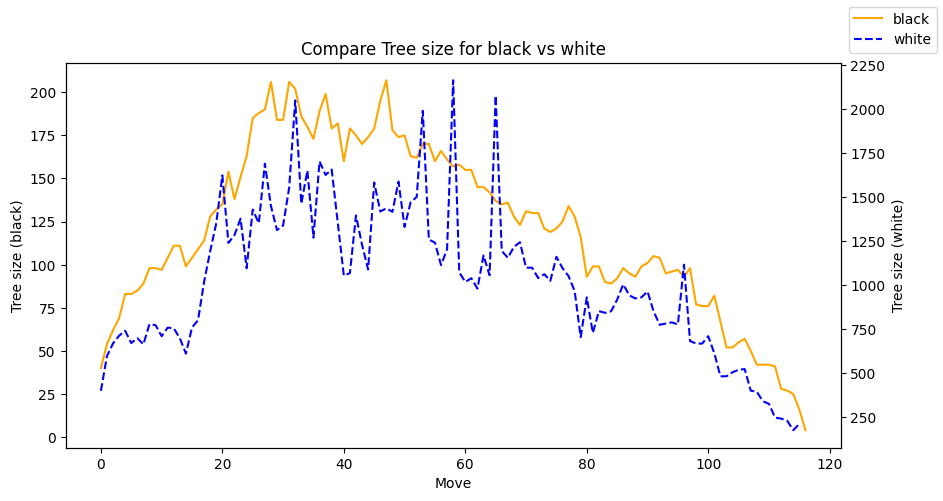

In [12]:
match_key = 'm-alphabeta-m-alphabeta_1-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.ADAPTIVE_WEIGHTS'
print(match_info(matches[match_key]))
plot_compare_two_players(*matches[match_key], 'Compute time')
plot_compare_two_players(*matches[match_key], 'Jump size')
plot_compare_two_players(*matches[match_key], 'Eval value')
plot_compare_two_players(*matches[match_key], 'Tree size')

Match between static_weights VS distance, where winner is Black


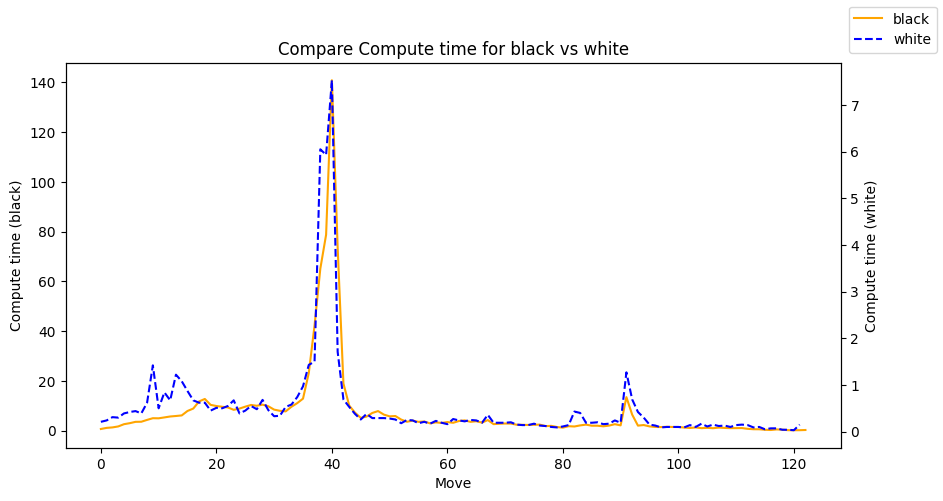

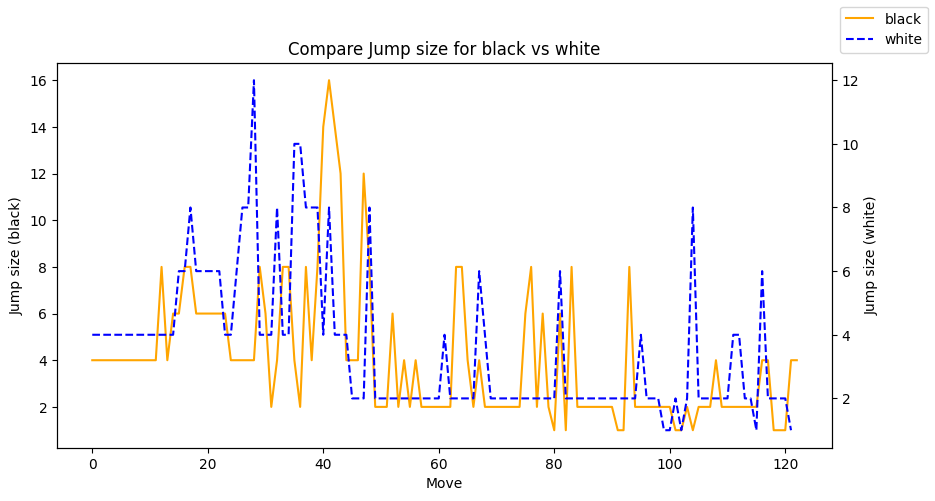

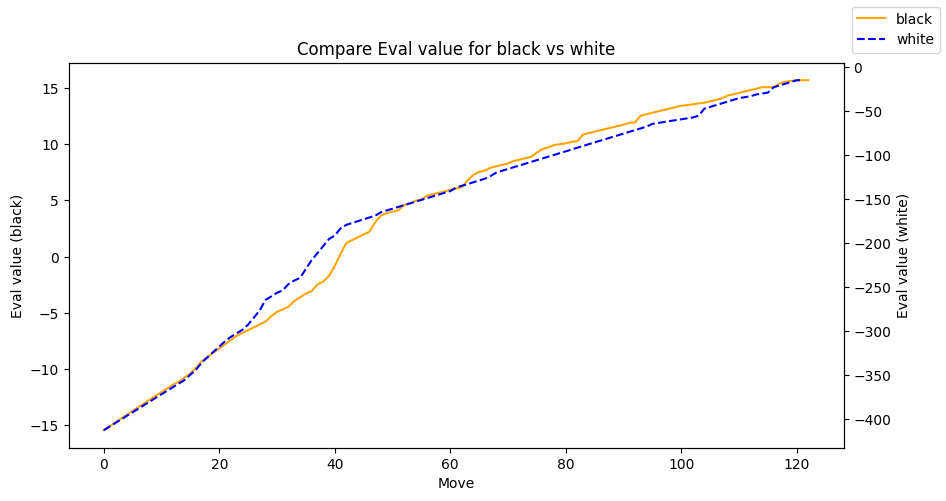

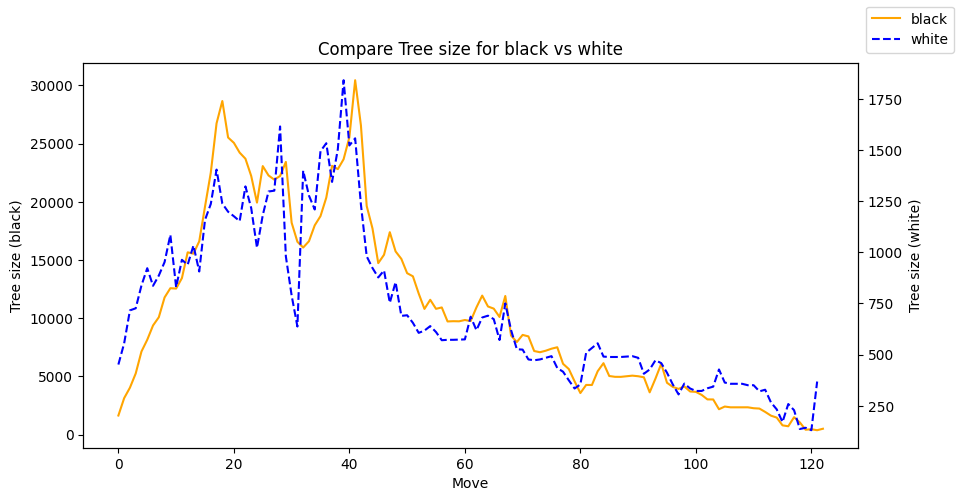

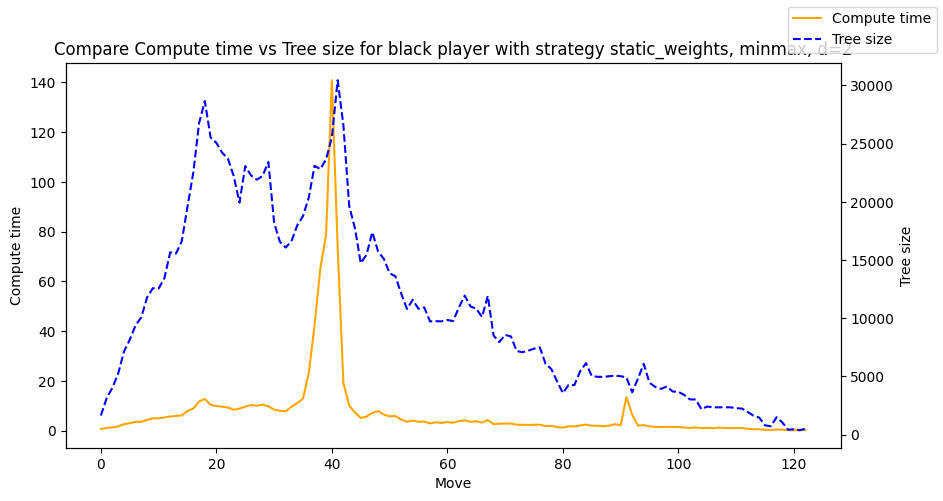

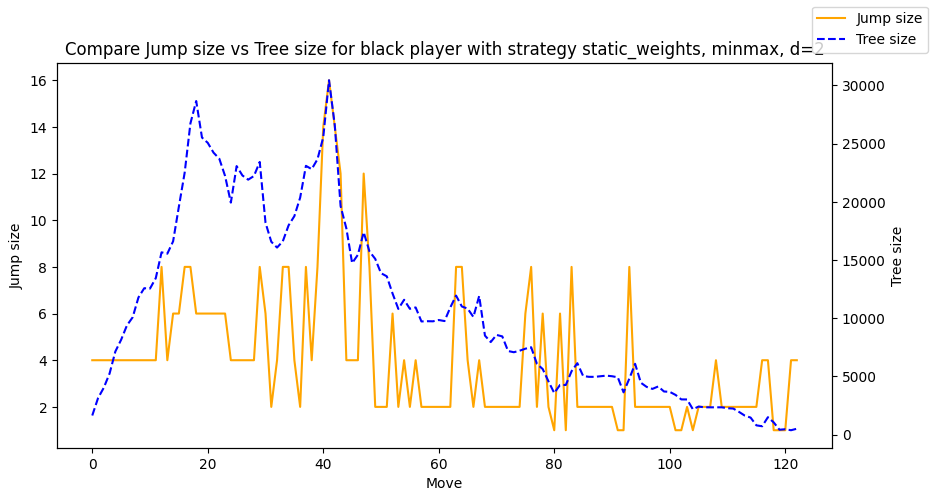

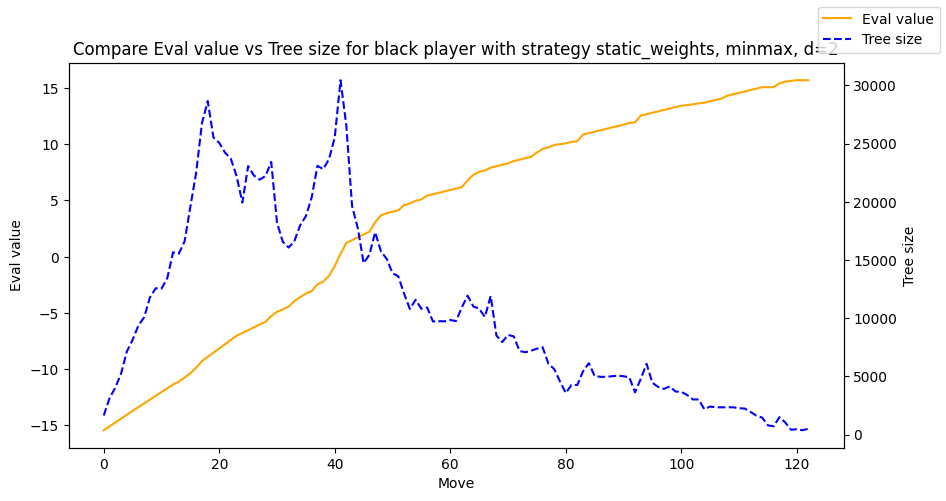

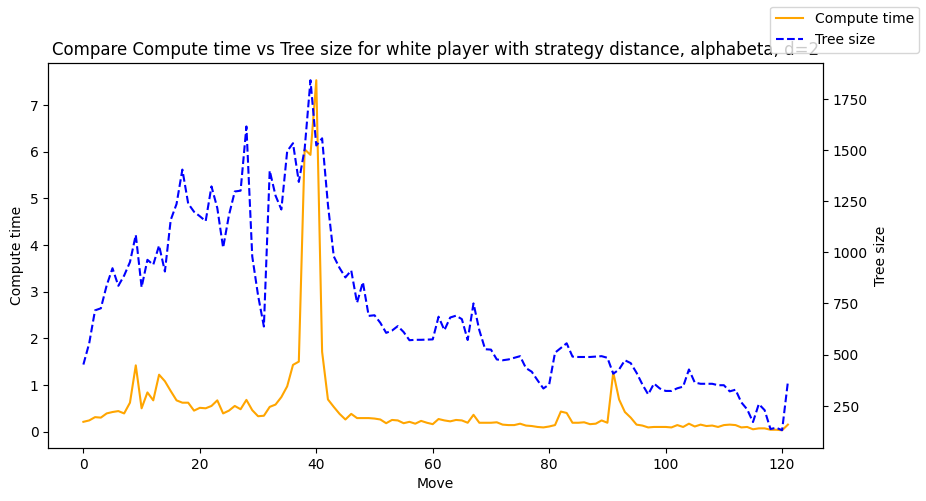

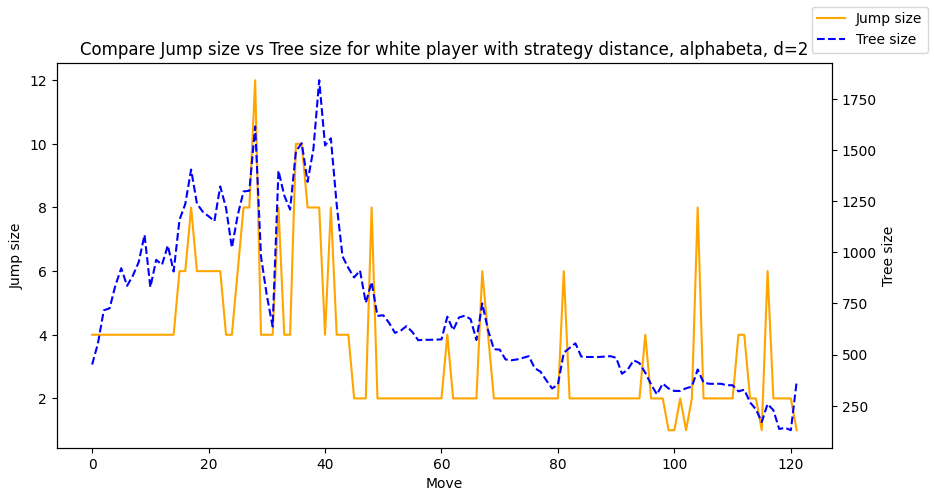

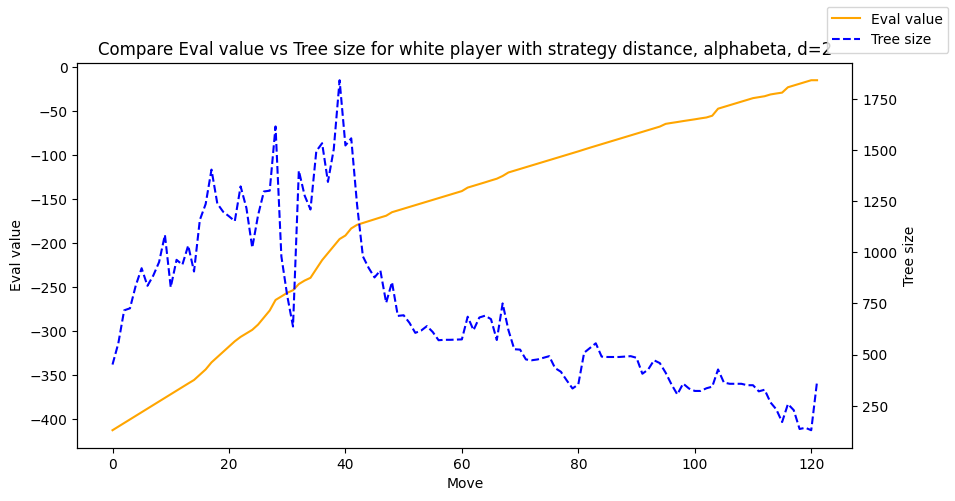

In [13]:
match_key = 'm-minmax-m-alphabeta_2-2_STRATEGY.STATIC_WEIGHTS-STRATEGY.DISTANCE'
print(match_info(matches[match_key]))
plot_compare_two_players(*matches[match_key], 'Compute time')
plot_compare_two_players(*matches[match_key], 'Jump size')
plot_compare_two_players(*matches[match_key], 'Eval value')
plot_compare_two_players(*matches[match_key], 'Tree size')
for player_id in range(2):
    plot_compare_two_variables(matches[match_key][player_id], 
                               'Compute time', 'Tree size')
    plot_compare_two_variables(matches[match_key][player_id], 
                               'Jump size', 'Tree size')
    plot_compare_two_variables(matches[match_key][player_id], 
                               'Eval value', 'Tree size')

#### Obserwacje

Dla większości meczy jest prawdą, że najbardziej intensywne "myślenie" (mierzone wielkością przeszukanego drzewa) zachodzi raczej w początku gry (20-40 ruch), niż na środku. Również wartość funkcji ewaluującej szanse na wygraną rosną, co jest oznaką prawidłową. Wartości czasu obliczeń nie powinny być zbytnio brane pod uwagę, gdyż mecze były grane na wielu równoległych procesach, co mogło mieć jakiś wpływ na czas (aczkolwiek raczej to nie to).

In [14]:
match_stats = pd.concat([get_match_stats(*matches[k]) for k in matches])

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: FutureWarning: The provided callable <function mean at 0x000001F0FEE1B100> is currently using Series.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats_df = df[['Compute time', 'Tree size', 'Eval value', 'Jump size']].agg([np.mean, np.sum, np.max, np.min])
C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: FutureWarning: The provided callable <function sum at 0x000001F0FEE1A020> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  stats_df = df[['Compute time', 'Tree size', 'Eval value', 'Jump size']].agg([np.mean, np.sum, np.max, np.min])
C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: 

In [15]:
finished_matches_stats = pd.concat([get_match_stats(*matches[k]) for k in finished_matches])

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: FutureWarning: The provided callable <function mean at 0x000001F0FEE1B100> is currently using Series.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats_df = df[['Compute time', 'Tree size', 'Eval value', 'Jump size']].agg([np.mean, np.sum, np.max, np.min])
C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: FutureWarning: The provided callable <function sum at 0x000001F0FEE1A020> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  stats_df = df[['Compute time', 'Tree size', 'Eval value', 'Jump size']].agg([np.mean, np.sum, np.max, np.min])
C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: 

In [16]:
ongoing_matches_stats = pd.concat([get_match_stats(*matches[k]) for k in ongoing_matches])

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: FutureWarning: The provided callable <function mean at 0x000001F0FEE1B100> is currently using Series.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats_df = df[['Compute time', 'Tree size', 'Eval value', 'Jump size']].agg([np.mean, np.sum, np.max, np.min])
C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: FutureWarning: The provided callable <function sum at 0x000001F0FEE1A020> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  stats_df = df[['Compute time', 'Tree size', 'Eval value', 'Jump size']].agg([np.mean, np.sum, np.max, np.min])
C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\halma_game\evaluation\computation.py:16: 

In [17]:
finished_matches_stats

,Compute time,Tree size,Eval value,Jump size,player,strategy,algorithm,depth,match,winner
mean,0.06,89.01,3.79,4.25,Black,adaptive_weights,alphabeta,1,m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_...,Black
sum,6.34,9880.00,421.04,472.00,Black,adaptive_weights,alphabeta,1,m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_...,Black
max,0.32,183.00,15.68,24.00,Black,adaptive_weights,alphabeta,1,m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_...,Black
min,0.00,1.00,-15.08,1.00,Black,adaptive_weights,alphabeta,1,m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_...,Black
mean,0.10,126.48,-165.34,3.85,White,distance,alphabeta,1,m-alphabeta-m-alphabeta_1-1_STRATEGY.ADAPTIVE_...,Black
...,...,...,...,...,...,...,...,...,...,...
min,0.03,90.00,-15.42,1.00,Black,static_weights,minmax,2,minmax-minmax_2-2_STRATEGY.STATIC_WEIGHTS-STRA...,Black
mean,88.23,14664.77,-99.46,3.65,White,distance,minmax,2,minmax-minmax_2-2_STRATEGY.STATIC_WEIGHTS-STRA...,Black
sum,12969.90,2155721.00,-14619.96,537.00,White,distance,minmax,2,minmax-minmax_2-2_STRATEGY.STATIC_WEIGHTS-STRA...,Black
max,2666.69,64264.00,0.62,18.00,White,distance,minmax,2,minmax-minmax_2-2_STRATEGY.STATIC_WEIGHTS-STRA...,Black


Obserwacja: wygrana nie zawsze zależy od głębokości drzewa

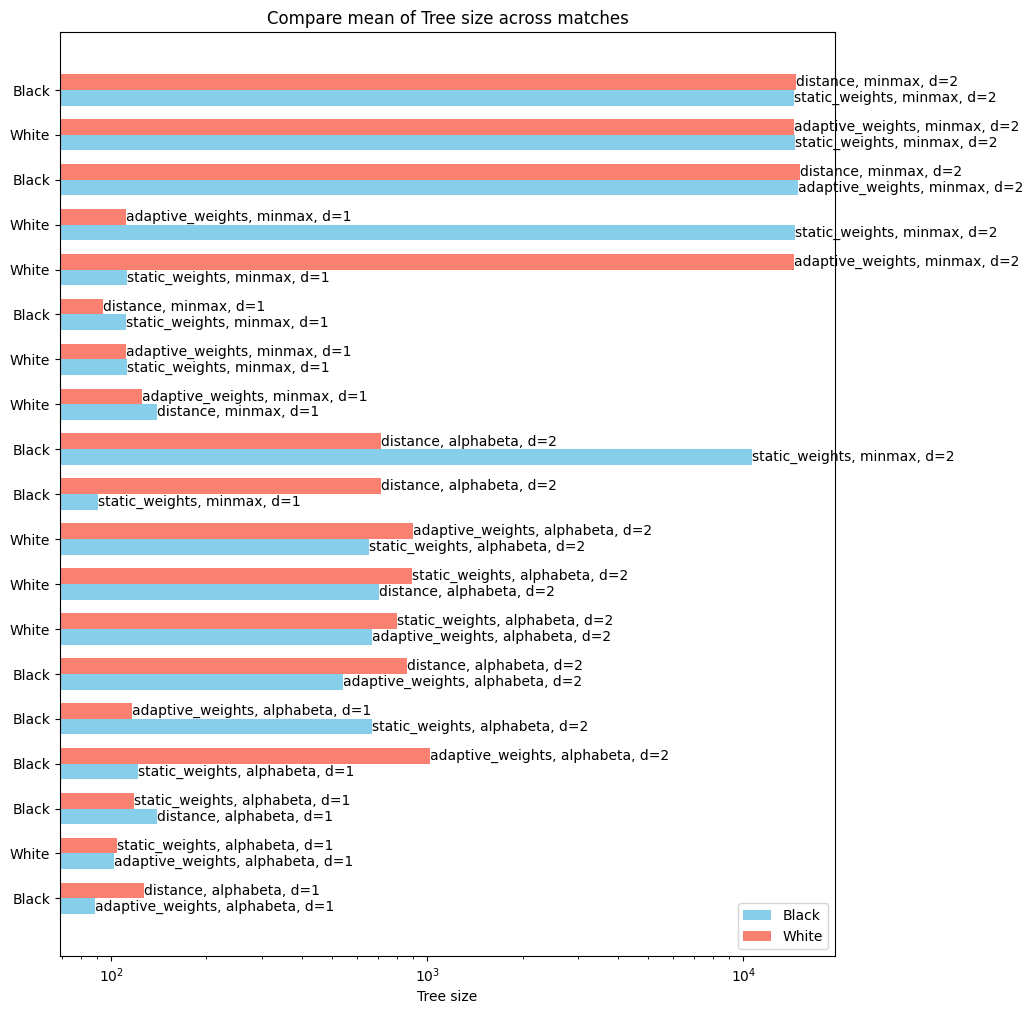

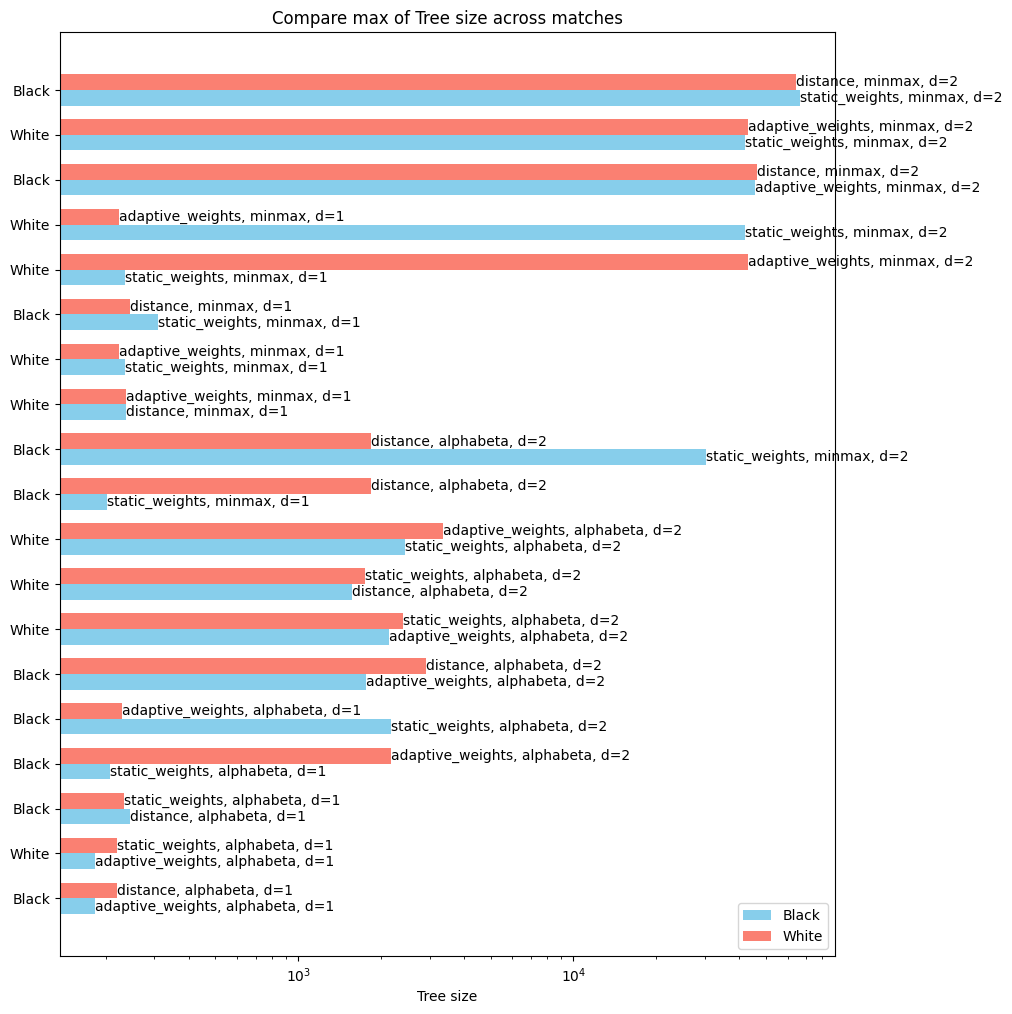

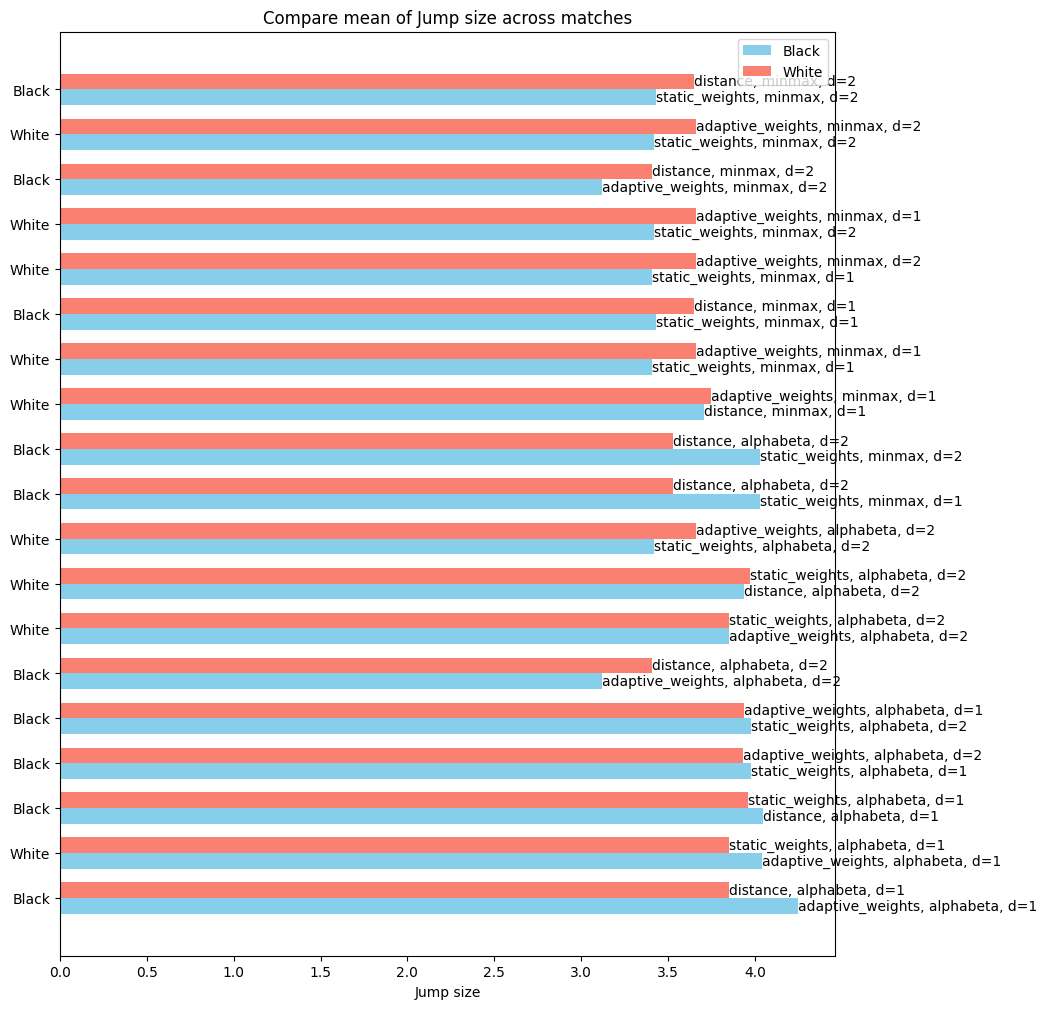

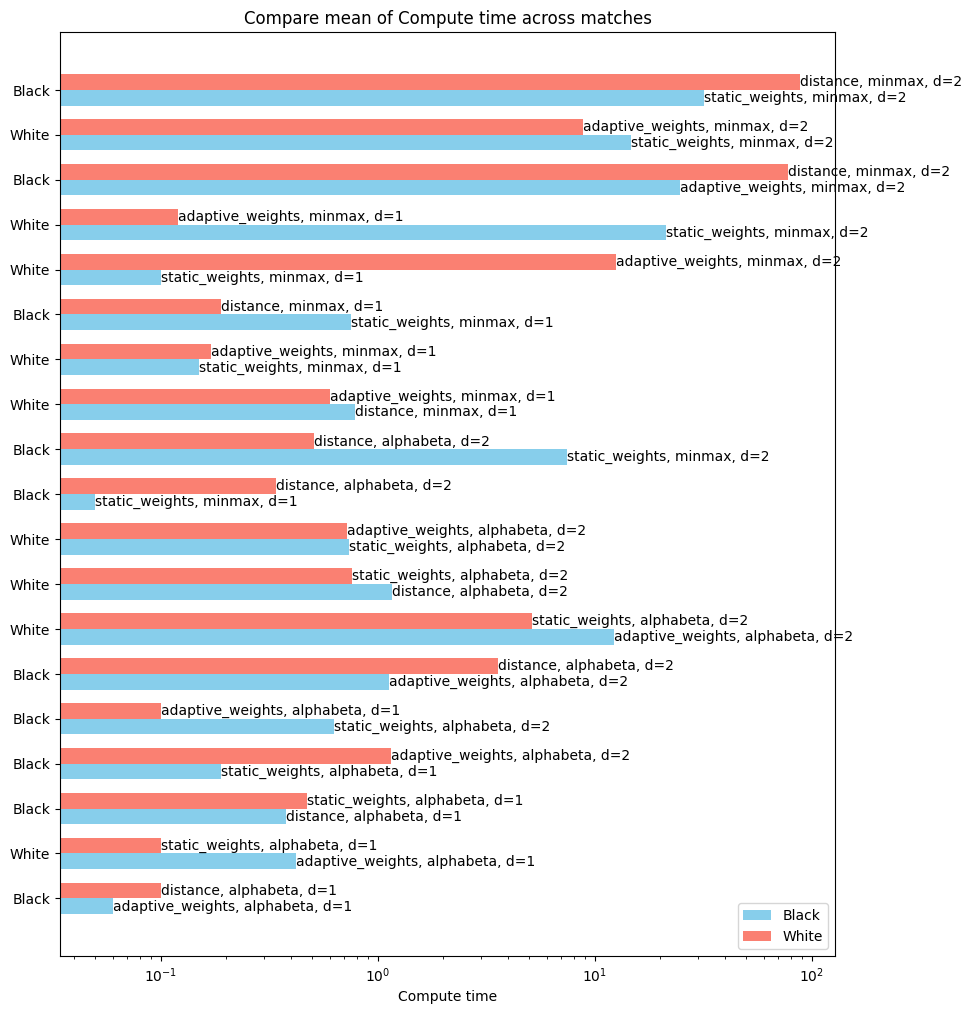

In [26]:
plt.figure(figsize=(10, 12))
compare_matches(finished_matches_stats, 'mean', 'Tree size', scale='log')
plt.figure(figsize=(10, 12))
compare_matches(finished_matches_stats, 'max', 'Tree size', scale='log')
plt.figure(figsize=(10, 12))
compare_matches(finished_matches_stats, 'mean', 'Jump size')
plt.figure(figsize=(10, 12))
compare_matches(finished_matches_stats, 'mean', 'Compute time', scale='log')

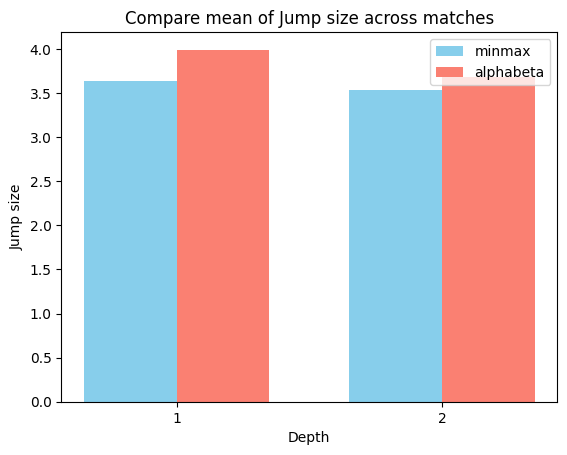

In [19]:
compare_algorithms(finished_matches_stats, 'mean', 'Jump size', ['1', '2'], ['minmax', 'alphabeta'])

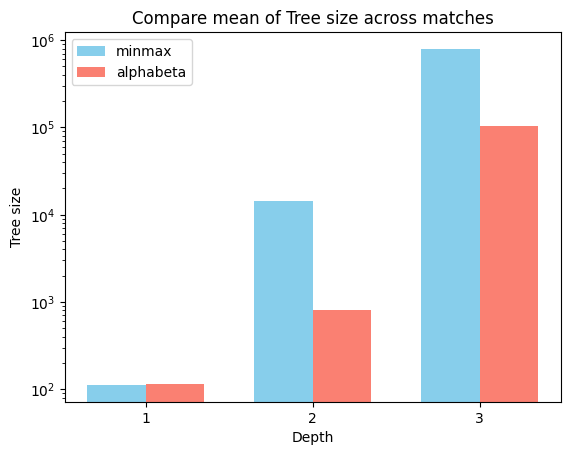

In [20]:
compare_algorithms(match_stats, 'mean', 'Tree size', ['1', '2', '3'], ['minmax', 'alphabeta'], scale='log')

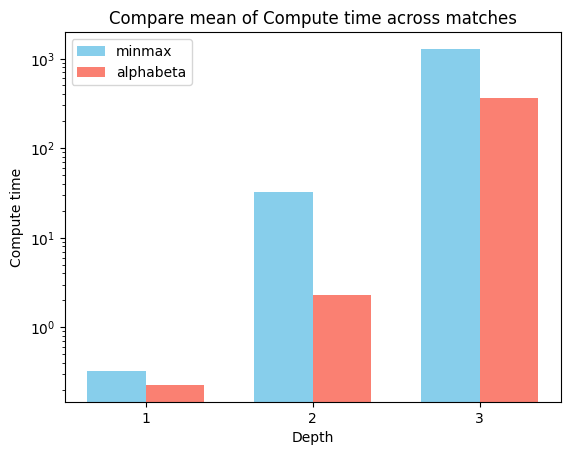

In [27]:
compare_algorithms(match_stats, 'mean', 'Compute time', ['1', '2', '3'], ['minmax', 'alphabeta'], scale='log')

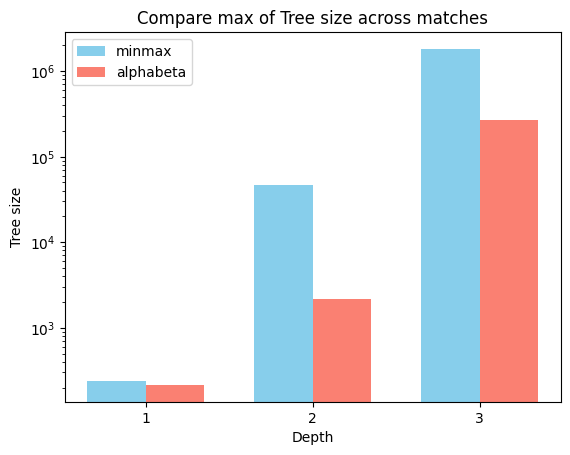

In [21]:
compare_algorithms(match_stats, 'max', 'Tree size', ['1', '2', '3'], ['minmax', 'alphabeta'], scale='log')

TODO: zrobić ranking strategii, skala logarytmiczna?

In [22]:
def get_winner(match):
    if match[0].winner != 'None':
        return match[0] if match[0].winner.endswith('BLACK') else match[1]

In [23]:
finished_matches_stats.loc[finished_matches_stats['player'] == finished_matches_stats['winner']].drop_duplicates('match').groupby('strategy').count()['winner']

strategy
adaptive_weights    9
distance            1
static_weights      9
Name: winner, dtype: int64

strategy
adaptive_weights    13
distance            10
static_weights      15
Name: winner, dtype: int64

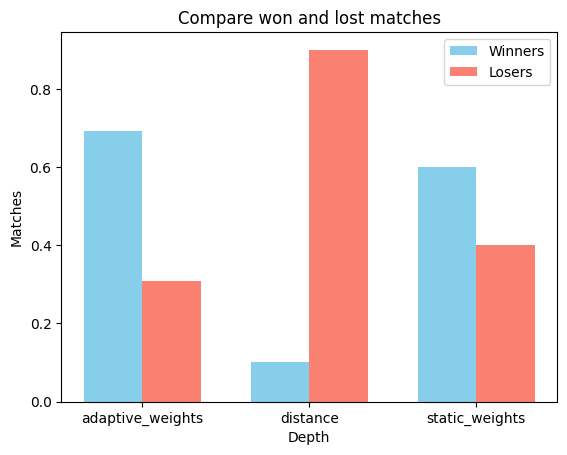

In [24]:
matches = compare_wins_loses_between_strategies(finished_matches_stats)
matches

### Mecze niedokończone 

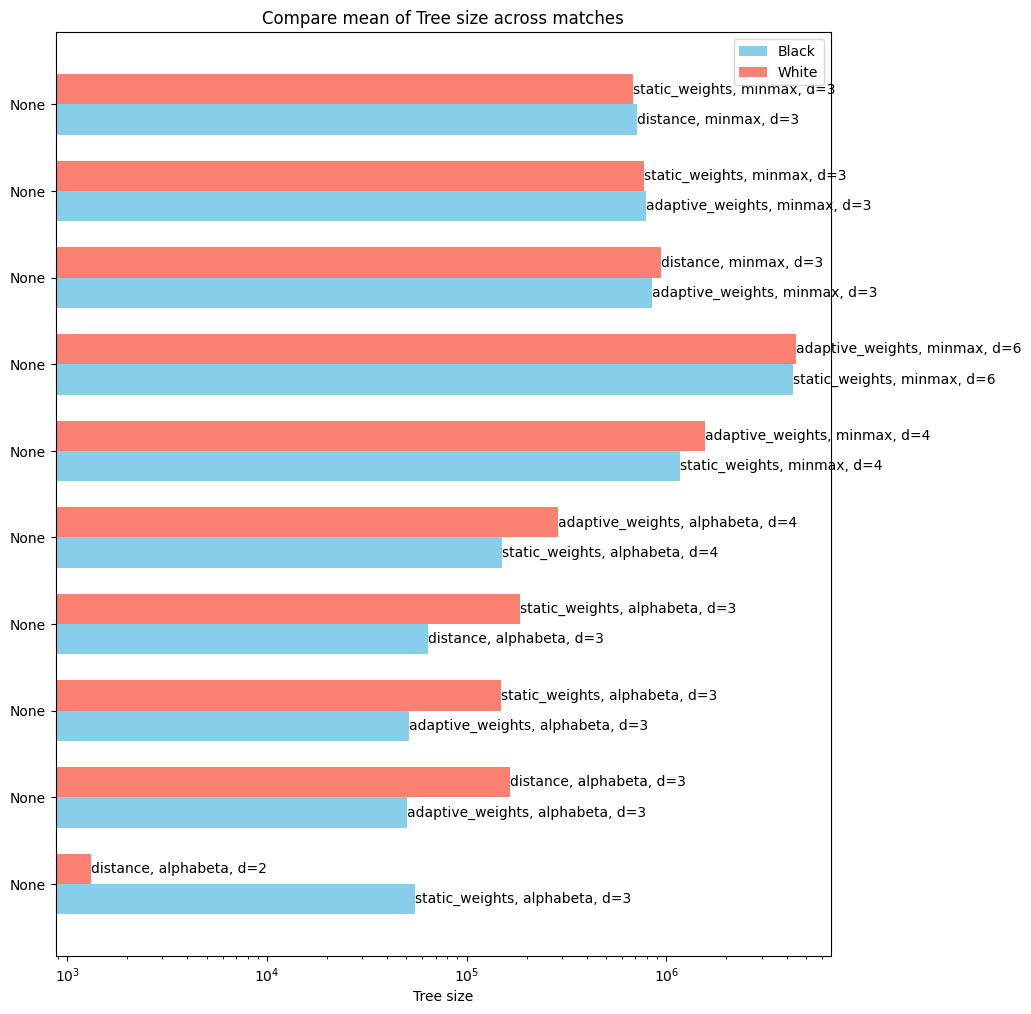

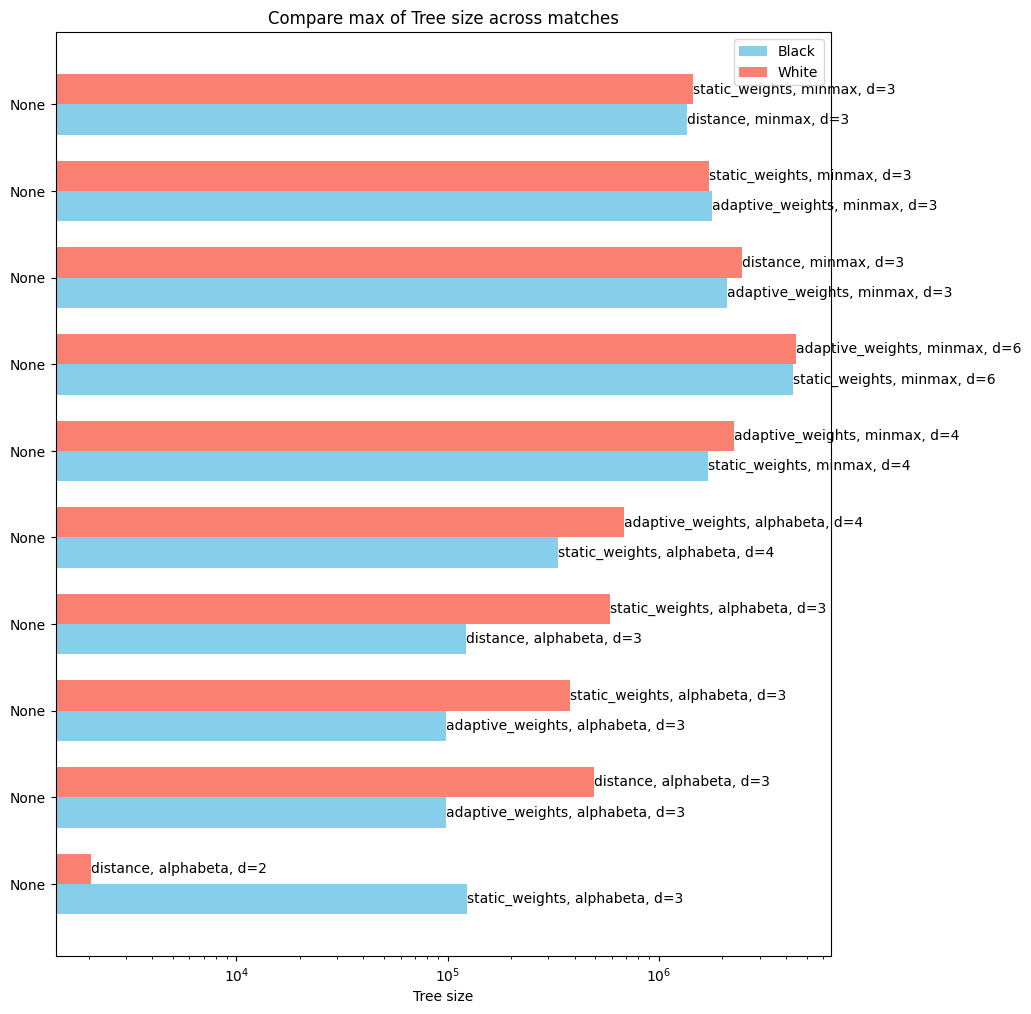

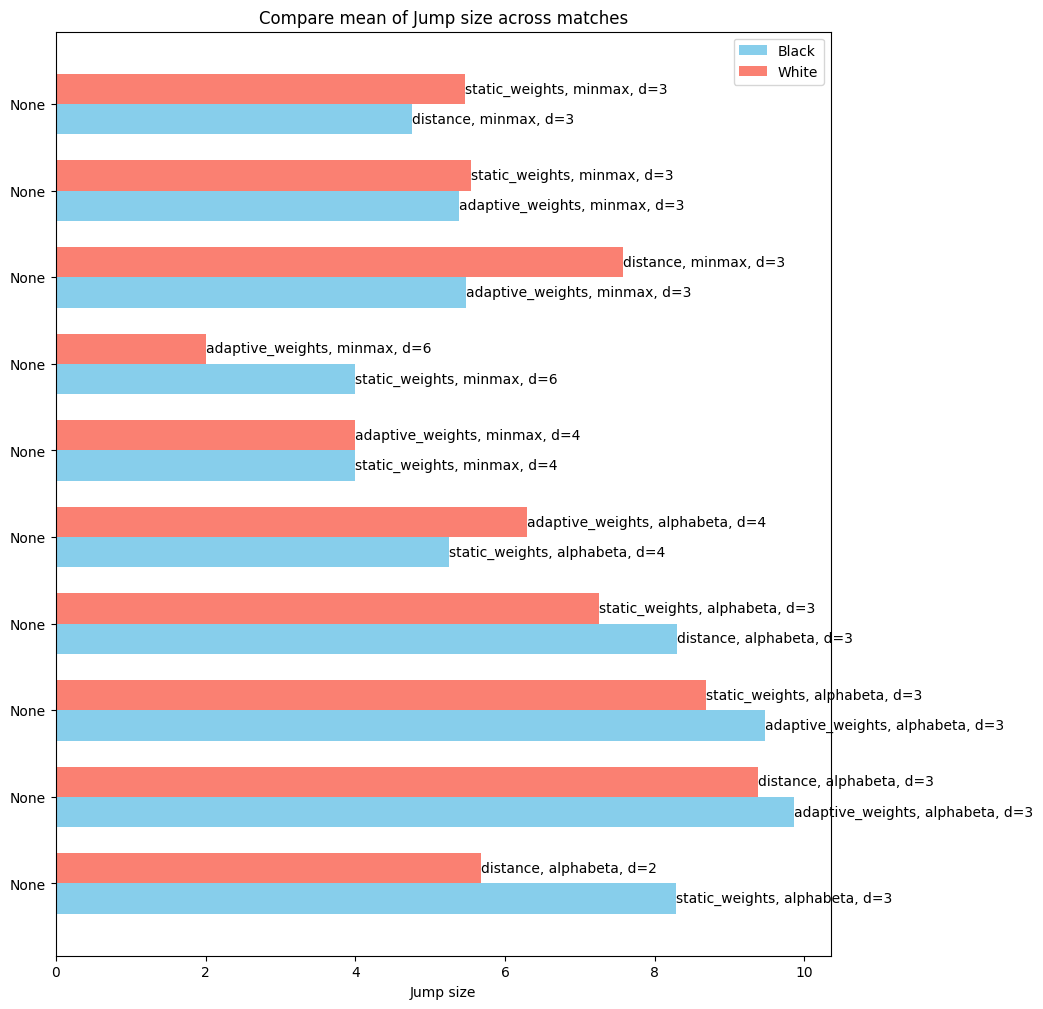

In [25]:
plt.figure(figsize=(10, 12))
compare_matches(ongoing_matches_stats, 'mean', 'Tree size', scale='log')
plt.figure(figsize=(10, 12))
compare_matches(ongoing_matches_stats, 'max', 'Tree size', scale='log')
plt.figure(figsize=(10, 12))
compare_matches(ongoing_matches_stats, 'mean', 'Jump size')